# Compare SVC with Random Forest (classification)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
df = pd.read_csv('/Users/Gabriele/Desktop/ml/mldata_0013052606/mldata_0013052606.csv')
n_samples, n_features = df.shape

First of all, let's give a look at the data that we have: it's very important that we feed the right data to the models.

- By looking at the features given, it is clear that there's an accidental repetition of feature_3, so I dropped feature_6 column since it's not needed for the classification task. 
- y_label is the dependent variable that needs to be predicted.

In [4]:
X = df.drop(['label','Unnamed: 0','feature_6'], axis=1)
y_label = df['label']

## Preprocess the data

Data rarely comes in a clean format: preprocessing data is about taking the information about the dataset and turning it into numbers that can be used as features, which I have called X.

### Feature importance using Random forest
Decision tree makes splits that maximize the decrease in impurity. By calculating the mean decrease in impurity for each feature across all trees we know that feature's importance. 

One of the methods to assess the quality of a split is Gini impurity, which (as all other impurity functions) measures impurity of the outputs after a split. When training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of each variable (shown in the graph below).

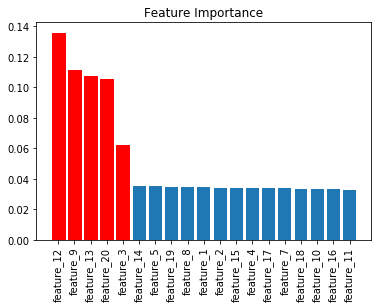

In [71]:
#create the model for calculating feature importances
clf = ExtraTreesClassifier(n_estimators=200, random_state=0, n_jobs=-1)
model = clf.fit(X, y_label)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [list(X)[i] for i in indices]

# Create plot
plt.figure()
plt.title("Feature Importance")
plot = plt.bar(names, importances[indices])
[plot[i].set_color('r') for i in range(5)]
plt.xticks(names, names, rotation=90)
plt.show()

- The features that I painted in red seem to explain more variation in y (for feature 12 it almost reaches 14%)

## Correlation analysis

Let's look also at the correlation matrix, which is just a table showing the correlation coefficients between variables.

The performance of some models can deteriorate if two or more variables are tightly related, especially when we are dealing with linear methods (such as the linear SVC I have to use in my case).
But as the matrix shows, it seems that by measuring the Pearson's correlation there's no strong linear relationship among variables. 

Text(0.5, 1.0, 'All Correlations')

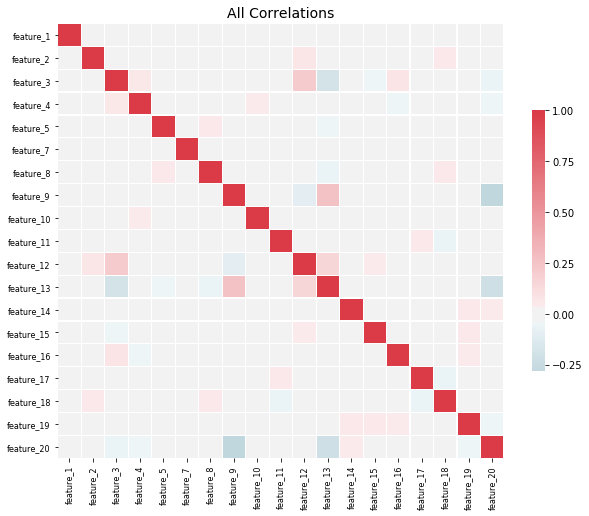

In [72]:
corr_matrix_plot = X.corr()
title = "All Correlations"     
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
            linewidths=.25, cbar_kws={"shrink": 0.6})

# Set the ylabels 
ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

# Set the xlabels 
ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
plt.title(title, size = 14)

### Overfitting solution: cross validation

What we want to do with our models is to *absolutely* avoid overfitting, which means adding additional features that fit noise in the training data. So I implemented a cross validation method to overcome this issue as it is standard procedure (and it's also very efficient). Hence, it's not needed to manually split the dataset between training and testing data, since by applying K-fold the process is algorithmically done in a more efficient way. Briefly, K-fold cross-validation follows this procedure:
- It shuffles the data and partitions it in k equally-sized blocks;
- For i = 1,...,k,
    - Train the model on all data except block i,
    - Evaluate the model using block i
- Average the *k* validation errors, which means estimating the final true error

In addition, this solution allows to use the entire dataset to train the model, which can improve the quality of the model considerably (especially when you don't have much samples to use).

In [5]:
sfold = StratifiedKFold(10, random_state=1)
n_folds = 10

## Classification model: Random Forest

Let's try first to define the Random Forest model and to give a first look at the accuracy score. This ensemble learning method is based on "asking" the decision trees to classify a point and then to take a majority vote.
The model gave an accuracy score of about 74% in classifying correcly the dataset, by using the default value of n_estimator of 100 and 
max_depth = "None" (the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples).

In [6]:
model_rf = ExtraTreesClassifier(n_estimators = 100)
scores_rf = cross_val_score(model_rf, X, y_label, cv=sfold, scoring='accuracy')
print('Random Forest Classifier')
print('Accuracy scores for every block:', scores_rf)
print('Accuracy scores mean:', np.mean(scores_rf))

Random Forest Classifier
Accuracy scores for every block: [0.71755725 0.81679389 0.76335878 0.70992366 0.80152672 0.6870229
 0.76744186 0.76744186 0.69767442 0.71653543]
Accuracy scores mean: 0.7445276778712621


### Task: Model hyperparameters tuning
This step consists in finding the hyperparameters that produce the best model (that is, the one that achieves the highest accuracy). 
First of all, we work on the **n_estimators** parameter: it represents the number of trees in the forest. Usually, the higher the number of trees, the better the model is to learn the data. However, adding a lot of trees can:
- slow down the training process considerably;
- give diminishing returns if you increase the parameter too much.

Therefore we do a parameter search to find the optimal number of trees.

In [8]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 300]
param_rf = {'n_estimators' : n_estimators}
grid_rf = GridSearchCV(model_rf, param_rf, cv=n_folds, scoring='accuracy',iid= True)
grid_rf.fit(X, y_label)
print('The best accuracy score is:', grid_rf.best_score_)
print('Achieved with a value of n_estimators of:', grid_rf.best_params_)

The best accuracy score is: 0.7607692307692308
Achieved with a value of n_estimators of: {'n_estimators': 300}


The second parameter that needs to be tuned is **Max_depth**. It represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. The function fits each decision tree with depths ranging from 15 up to 30 and plots the cross validated accuracy for each hyperparameter's value. The depth values go from 15 to 30 since not-so-deep trees are not able to capture enough information and it didn't make sense to calculate the accuracy score with them at all.

In [11]:
model_rf = ExtraTreesClassifier(n_estimators = 200)

max_depths = np.linspace(10, 30, 15, endpoint=True)
param_rf = {'max_depth' : max_depths}
grid_rf = RandomizedSearchCV(model_rf, param_rf, cv=sfold, scoring='accuracy', iid=True) 
grid_rf.fit(X, y_label)


print('The best accuracy score is:', grid_rf.best_score_)
print('Achieved with a value of max_depth of:', grid_rf.best_params_)

The best accuracy score is: 0.7676923076923077
Achieved with a value of max_depth of: {'max_depth': 28.571428571428573}


From the cross validation result, the max_depth of about 28.5 gave the best accuracy result (of about 76.7%). 

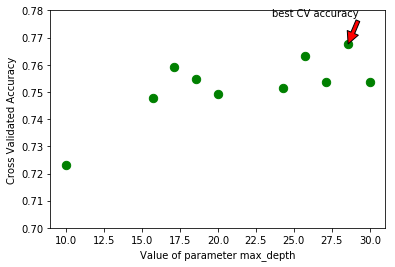

In [12]:
rndm_depths = grid_rf.cv_results_['param_max_depth']
grid_rf_scores = grid_rf.cv_results_['mean_test_score']
ax = plt.figure()
plt.xlabel('Value of parameter max_depth')
plt.ylabel('Cross Validated Accuracy')
plt.scatter(rndm_depths, grid_rf_scores, marker='o',color='green',s=70)

plt.annotate('best CV accuracy', xy= (grid_rf.best_params_['max_depth'],grid_rf.best_score_), 
             xytext=(grid_rf.best_params_['max_depth']-5,grid_rf.best_score_+0.01),
            arrowprops=dict(facecolor='red', shrink=1),
            )

plt.ylim(0.7,0.78)
plt.show()

By using the two parameters (number of trees = 200 and maximum of each tree = 28.5), and trying to fit the model again, the overall accuracy goes **up to 76.7%**

By trying also to tune additional model parameters, such as: 

- the **criterion** to measure the quality of each split ("gini" method or "entropy" method)
- using **bootstrap** samples when building the decision trees (which means to create many random sub-samples of the dataset with replacement and then training each decision the trees on each sub-sample),
- switching on **warm_start** (which allows to reuse the existing fitted model attributes to initialise the new model in a subsequent call to fit)
- setting **min_samples_split** (which just indicates the minimum number of samples required to split an internal node),

**the overall performance of the algorithm does not improve in a significant way**. Therefore, the various combinations of the parameters warm_start, min_samples_split, bootstrap and criterion are omitted from the procedure.

## Classification model: SVM Classifier

Given labeled training data (supervised learning), the SVM classifier outputs an optimal hyperplane which categorizes the samples. How is the optimal hyperplane defined? It is the one that maximises the **margin** between the classes, so that the solution is the most stable one under perturbations of the inputs.

In [55]:
#SVM (Classifier)
model_svc = LinearSVC(max_iter = 100000)
scores_svc = cross_val_score(model_svc, X, y_label, cv=sfold, scoring='accuracy')

print('Linear Support Vector Classifier')
print('Accuracy scores mean:', np.mean(scores_svc))

Linear Support Vector Classifier
Accuracy scores mean: 0.5736924283363922


### Task: Model hyperparameters tuning

To also check if by introducing the slack variable **"C"** the model improves the accuracy, let's try to cross validate with 4 different values of C to see which one gives the best accuracy.

In [62]:
Cs = [0.001, 0.1, 1, 10]
param_svc = {'C': Cs}
grid_svc = GridSearchCV(model_svc, param_svc, cv=sfold, scoring='accuracy',iid= True)
grid_svc.fit(X, y_label)


print('The best accuracy score is:', grid_svc.best_score_)
print('Achieved with a value of C of:', grid_svc.best_params_['C'])

The best accuracy score is: 0.5846153846153846
Achieved with a value of C of: 0.001


The "C" parameter is a regularization parameter known as "soft margin":
- small C allows constraints to be easily ignored → large margin of the support vector;
- large C makes constraints hard to ignore → narrow margin 
- C = ∞ enforces all constraints: hard margin

Trying to optimize the value of C by cross-validation, the result gives 0.001 as the value that gives the best accuracy of the model, by scoring 58.4% of accuracy. This is clearly not a very significative improvement to the model.

The **tolerance** parameter indicates the tolerance of the stopping criteria; it is used to decide when to stop searching for a minimum of the function, once you're close enough to the target accuracy.

In [27]:
model_svc = LinearSVC(max_iter = 100000, C = 0.001)
tol = np.linspace(1e-4, 1000, 100)
param_svc = {'tol' : tol}
grid_svc = GridSearchCV(model_svc, param_svc, cv=sfold, scoring='accuracy', iid=True) 
grid_svc.fit(X, y_label)

print('The best accuracy score is:', grid_svc.best_score_)
print('Achieved with a tolerance of:', grid_svc.best_params_["tol"])

The best accuracy score is: 0.6015384615384616
Achieved with a tolerance of: 232.3233090909091


The optimal value can change a lot depending due to noise, but for our dataset a value between 50 and 900 will generally yield the best result (around **60%**)

By also trying to tune the following parameters:
- **multi_class** parameter is used to handle the data when the dependent variable contains more than two labels (as in our case). "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes (the second method rarely leads to better accuracy and created a convergence problem so I decided to not show it at all),
- **fit_intercept** needs to take the value True (the default one) since our data is not centered,
- **loss** specifies the loss function, which can be 'hinge' or 'squared hinge' (by default),
- **dual** is set to True since in our case the number of samples >> number of features (so that it solves the dual optimization problem)

**The overall accuracy score of the model does not change significantly**, so their tuning is purposely omitted from the process.

My guess is that **a linear separator is not an appropriate decision boundary for this task**. So let's try to redefine the linear model so that the **kernel method** can be applied (to deal with non-linearly separable data).
Basically kernels provide a powerful way to allow nonlinear decision boundaries, so let's test the score for each of the most commonly used kernels (rbf, polynomial and sigmoid kernels)

In [24]:
model_svc = SVC(gamma = 'auto')
scores_svc = cross_val_score(model_svc, X, y_label, cv=sfold, scoring='accuracy')

#Choosing the best kernel by cross validation
kernels = ['rbf', 'poly','sigmoid']
param_svc = {'kernel' : kernels}
grid_svc = GridSearchCV(model_svc, param_svc, cv=sfold, scoring='accuracy',iid = True)
grid_svc.fit(X, y_label)
print('The best accuracy score is:', grid_svc.best_score_)
print('Achieved with kernel', grid_svc.best_params_['kernel'])

The best accuracy score is: 0.7315384615384616
Achieved with kernel rbf


Text(0, 0.5, 'Cross Validated Accuracy')

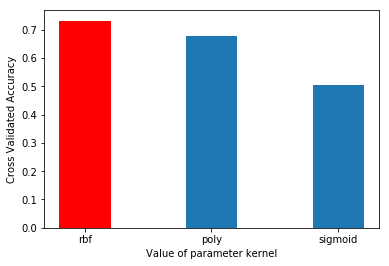

In [25]:
grid_svc_scores = grid_svc.cv_results_['mean_test_score']
ax = plt.bar(kernels, grid_svc_scores, width=0.4)
ax[0].set_color('r')
plt.xlabel('Value of parameter kernel')
plt.ylabel('Cross Validated Accuracy')

Radial Basis Function kernel is the one that gives the best accuracy score (**73.15%**) and performed slightly better that the polynomial kernel (67.9%)

So I tried to optimize the linear model with RBF kernel by tuning the value of **Gamma**. This parameter is basically the ‘spread’ of the kernel and therefore the decision region. 
- when the value is low, the ‘curve’ of the decision boundary is very low and thus the decision region is very broad 
- When high, the curve of the decision boundary is high, which creates islands of decision-boundaries around data points.

In [119]:
model_svc_rbf = SVC(kernel = 'rbf')
gamma = [0.1,1,10,100]
param_svc = {'gamma' : gamma}
grid_svc_rbf = GridSearchCV(model_svc_rbf, param_svc, cv=sfold, scoring='accuracy',iid= True)
grid_svc_rbf.fit(X, y_label)

print('The best accuracy score is:', grid_svc_rbf.best_score_)
print('Achieved with a value of gamma of:', grid_svc_rbf.best_params_['gamma'])

The best accuracy score is: 0.7330769230769231
Achieved with a value of gamma of: 0.1


So it turns out that when the value of Gamma is set to 0.1, we have a slight improvement in accuracy score for our rbf SVC model (**73.3%**)

## Conclusions

- choosing between a linear SVC with a "C" parameter of 0.001 and a tolerance criterion between 50 and 900, and random forest with a number of trees of 200 and a max depth of about 28, I would choose the random forest model without any doubt, mainly for its higher accuracy (76% against 60% of accuracy) and for the lower amount of time it took to tune its parameters. 

- the choice becomes harder when comparing the random forest model with SVC using the kernel method 'rbf' and choosing a value of gamma of 0.1: the model gave a result of 73.3% accuracy against a value of 76% accuracy for random forest. But it seems clear that for our dataset of 1300 samples and 19 features and by evaluating the accuracy score of each model using k-fold cross validation, **the best score is given by the random forest model, and so I would recommend to use this model with a number of trees of 200 and a max depth of 28 to perform the classification of the samples.**